# Maxcut problem

## **Step 0**: Setup and imports

In [1]:
# General imports
import os
import math
import numpy as np

# Qiskit circuits
from qiskit import QuantumCircuit
from qiskit.circuit.library import RealAmplitudes

# Qiskit primitives
from qiskit.primitives import Estimator as QiskitEstimator
from qiskit_aer.primitives import Estimator as AerEstimator
from qiskit.primitives import Sampler as QiskitSampler
from qiskit_aer.primitives import Sampler as AerSampler

# Qiskit runtime
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import Estimator, Sampler, Session

# Quantum serverless
from quantum_serverless import distribute_task, get
from quantum_serverless.core import Target

# quadratic_program
from quadratic_program import QuadraticProgram

# Docplex - classical description of optimization problems
from docplex.mp.model import Model

# translations
from translators import docplex_mp_to_qp
from translators import qubo_to_sparse_pauli_op

# workflows
from workflows import QuadraticProgramPostprocess, QuadraticProgramConverter

# SPSA
from spsa import minimize_spsa

# rustworkx graph library
import rustworkx as rs
from rustworkx.visualization import mpl_draw

## **Step 1** Map the problem to a Quantum Native format (Set of Operators, and a set of Quantum Circuits)

Specify optimization problem using docplex and convert to Quadratic Unconstained Binary Opimization (QUBO) problem that can be cast as an Ising Hamiltonian suitable for a quantum solution.

In [2]:
def random_adjacency_graph(N, density=0.5):
    """Build random adjacency graph of a given density

    Parameters:
        N (int): Matrx dimension
        density (float): Density of non-zero elements, default=0.5

    Returns:
        ndarray: Adjacency matrix as NumPy array
    """
    off_elems = N * (N - 1) // 2
    num_elems = math.ceil(off_elems * density)
    inds = np.sort(np.random.choice(off_elems, size=num_elems, replace=False))

    M = np.zeros((N, N), dtype=float)
    for k in inds:
        i = N - 2 - int(math.sqrt(-8 * k + 4 * N * (N - 1) - 7) / 2 - 0.5)
        j = k + i + 1 - N * (N - 1) // 2 + (N - i) * ((N - i) - 1) // 2
        M[i, j] = 1

    M = M + M.T
    return M

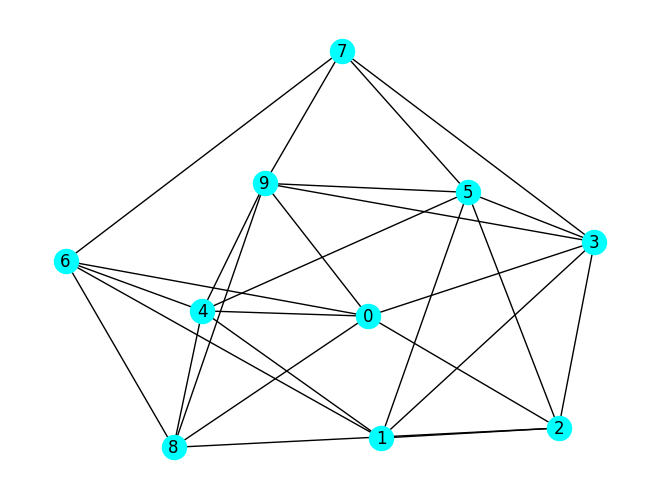

In [3]:
N = 10
density = 0.6
M = random_adjacency_graph(N, density)

G = rs.PyGraph.from_adjacency_matrix(M)
mpl_draw(G, with_labels=True, node_color="cyan")

In [4]:
mdl = Model(name="Max-cut")
x = {i: mdl.binary_var(name=f"x_{i}") for i in range(G.num_nodes())}
objective = mdl.sum(
    w * x[i] * (1 - x[j]) + w * x[j] * (1 - x[i]) for i, j, w in G.weighted_edge_list()
)
mdl.maximize(objective)
# print(mdl.export_as_lp_string())

### Convert to our `QuadraticProgram` format

In [5]:
qp = docplex_mp_to_qp(mdl)
# print(qp.prettyprint())

### Classical transformation to QUBO problem and Ising Hamiltonian

In [6]:
quadratic_transformer = QuadraticProgramConverter()
qubo = quadratic_transformer.run(qp)
# print(qubo.prettyprint())

In [7]:
hamiltonian, offset = qubo_to_sparse_pauli_op(qubo)

### Select ansatz circuit from circuit library

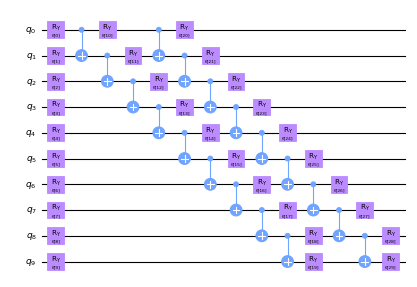

In [8]:
ansatz = RealAmplitudes(hamiltonian.num_qubits, entanglement="linear", reps=2)
ansatz.decompose().draw("mpl", idle_wires=False, fold=-1, scale=0.4)

## **Step 2**: Optimize the circuits and the operators to be measured.

Use the `selector` argument of `distribute_task` to facilitate automatic QPU selection. In this example, we use the `IBMLeastNoisyQPUSelector` to automatically select the least noisy backend with respect to a given circuit.

If qubits are requested and no selector is passed, the user may provide their Qiskit IBM Runtime token, and the least busy backend will be automatically selected.

In [9]:
from qiskit.transpiler import PassManager
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.transpiler.passes import ALAPScheduleAnalysis, PadDynamicalDecoupling
from qiskit.circuit.library import XGate

from quantum_serverless_tools.selectors import IBMLeastNoisyQPUSelector


@distribute_task(
    target={"qubits": ansatz.num_qubits},
    selector=IBMLeastNoisyQPUSelector(os.environ["QISKIT_IBM_TOKEN"], circuit=ansatz),
)
def transpile_circuit(ansatz: QuantumCircuit, **kwargs) -> tuple[QuantumCircuit, str]:
    print(f'{kwargs["backend"]} selected as the least noisy backend.')
    backend = QiskitRuntimeService().get_backend(kwargs["backend"])
    target = backend.target
    pm = generate_preset_pass_manager(target=target, optimization_level=3)
    pm.scheduling = PassManager(
        [
            ALAPScheduleAnalysis(target=target),
            PadDynamicalDecoupling(target=target, dd_sequence=[XGate(), XGate()]),
        ]
    )

    return pm.run(ansatz), backend

##### Get the transpiled circuit and the selected backend from the `transpile_circuit` function.

2023-10-11 16:23:33,402	INFO worker.py:1633 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


(transpile_circuit pid=65872) ibmq_mumbai selected as the least noisy backend.


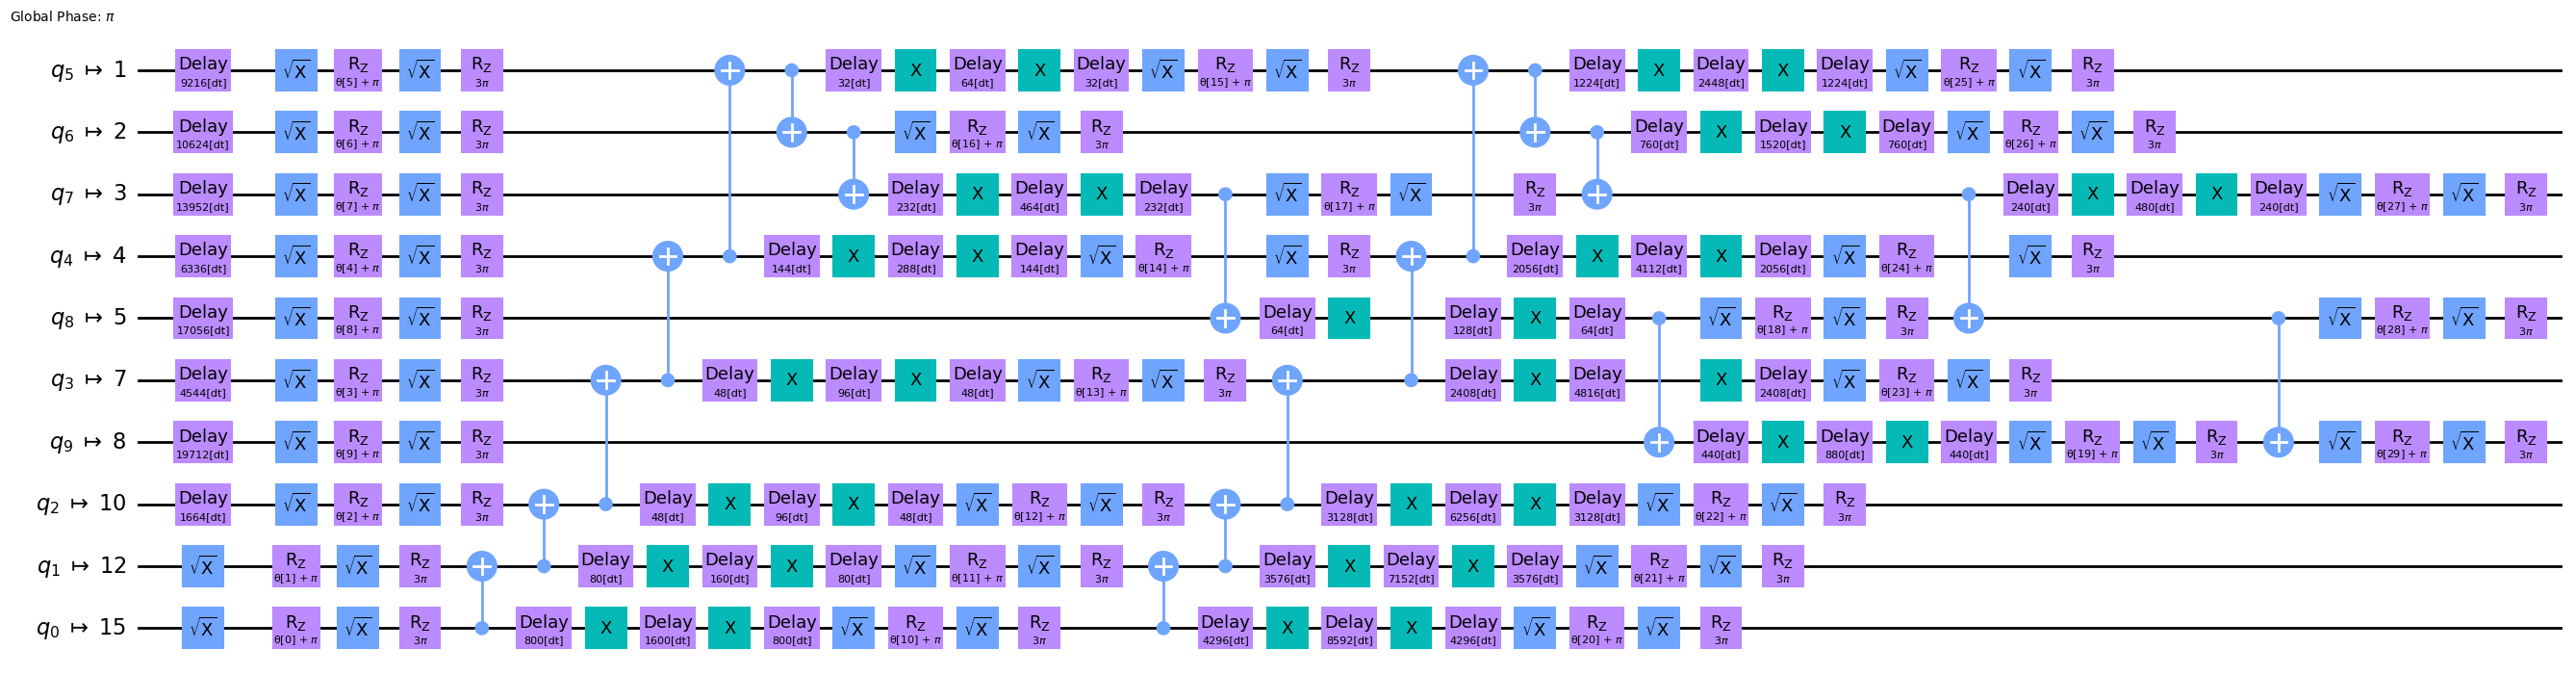

In [10]:
ansatz_ibm, backend = get(transpile_circuit(ansatz))

ansatz_ibm.draw("mpl", idle_wires=False, fold=-1)

In [11]:
from permute_sparse_pauli_op import permute_sparse_pauli_op

layout = ansatz_ibm.layout.initial_layout
hamiltonian_ibm = permute_sparse_pauli_op(hamiltonian, layout, ansatz.qubits)

In [12]:
%%capture

# Obtain index of the physical qubits to which the virtual qubits are mapped to
q_vir, q_phy = [], []
for k in range(backend.num_qubits):
    if (layout[k].index in range(N)) and (layout[k].register.name == "q"):
        q_vir.append(layout[k].index)
        q_phy.append(k)
qubit_map = dict(zip(q_vir, q_phy))
print(qubit_map)
q_phy_order = [qubit_map[k] for k in range(N)]
print(q_phy_order)

## **Step 3**: Execute using a quantum primitive function (estimator or sampler)

### Standard cost function definition

In [13]:
def cost_func(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (Estimator): Estimator primitive instance

    Returns:
        float: Energy estimate
    """
    cost = (
        estimator.run(ansatz, hamiltonian, parameter_values=params).result().values[0]
    )
    return cost

### Setup estimator and sampler instances

In [14]:
# session = Session(backend=backend)
# estimator = Estimator(session=session, options={"shots": int(1e4)})
# sampler = Sampler(session=session, options={"shots": int(1e4)})
# estimator = QiskitEstimator(options={"shots": int(1e4)})
# sampler = QiskitSampler(options={"shots": int(1e4)})

estimator = AerEstimator()
sampler = AerSampler()

### Perform minimization

In [15]:
x0 = 2 * np.pi * np.random.random(size=ansatz_ibm.num_parameters)
res = minimize_spsa(
    cost_func, x0, args=(ansatz_ibm, hamiltonian_ibm, estimator), maxiter=5
)
res

 message: Optimization terminated successfully.
 success: True
     fun: -0.287109375
       x: [ 2.582e+00  2.977e+00 ...  5.531e+00  8.934e+00]
     nit: 5
    nfev: 10

### Computute distribution at found minimum

In [16]:
from qiskit.circuit.classicalregister import ClassicalRegister

# Add measurements only for the active qubits in a proper order
cr = ClassicalRegister(N, "cr")
qc = ansatz_ibm.assign_parameters(res.x)
qc.add_register(cr)
qc.measure(q_phy_order, range(N))
samp_dist = sampler.run(qc, shots=int(1e4)).result().quasi_dists[0]
# Close the session since we are now done with it
# session.close()

## **Step 4**: Post-processing of the results to return either a plot or the answer
Transform quantum solution and convert back into classical variable space

In [17]:
solution = QuadraticProgramPostprocess(qubo, quadratic_transformer).run(samp_dist)
solution

array([0., 0., 1., 1., 1., 0., 1., 0., 0., 1.])

## Intepretation of solution

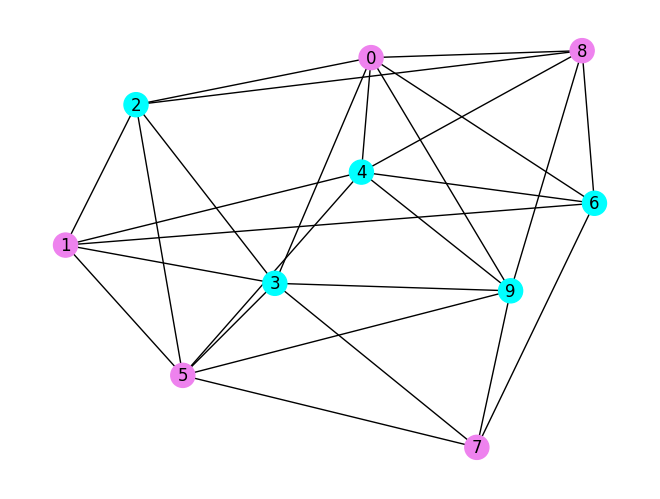

In [18]:
mpl_draw(
    G, with_labels=True, node_color=["cyan" if kk else "violet" for kk in solution]
)